In [434]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install xgboost-gpu

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# !pip install --upgrade xgboost

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [435]:
import os
import shutil
from git import Repo, Actor
from kaggle_secrets import UserSecretsClient # Untuk mengakses Kaggle Secrets
import sqlite3 # Modul untuk berinteraksi dengan database SQLite

# --- Konfigurasi (Sesuaikan dengan milik Anda) ---
# Nama pengguna GitHub Anda (bisa juga disimpan sebagai secret)
# GITHUB_USERNAME =  # Pastikan ini di-set, misal dari secret
# Nama repositori Anda (misalnya, "nama-repo-privat-saya")
REPO_NAME = "DataQuest"

# Nama berkas database SQLite yang ingin di-load/ubah dari GitHub
# (path relatif di dalam repo)
DATABASE_FILE_NAME_IN_REPO = "optuna_study3.db" # Ganti dengan nama berkas Anda

# Pesan commit
COMMIT_MESSAGE = f"Update database {os.path.basename(DATABASE_FILE_NAME_IN_REPO)} from Kaggle Notebook"

# Nama branch yang akan digunakan
BRANCH_NAME = "main" # atau "master", sesuaikan dengan repo Anda

# Direktori lokal di Kaggle untuk clone repo
LOCAL_REPO_PATH = f"/kaggle/working/{REPO_NAME}"

# --- Dapatkan Kredensial dari Kaggle Secrets ---
try:
    user_secrets = UserSecretsClient()
    GITHUB_PAT = user_secrets.get_secret("GITHUB_PAT")
    GITHUB_USERNAME = user_secrets.get_secret("GITHUB_USERNAME") # Pastikan Anda punya secret ini
    # GITHUB_EMAIL = user_secrets.get_secret("GITHUB_EMAIL") # Opsional, untuk git config
    # GITHUB_DISPLAY_NAME = user_secrets.get_secret("GITHUB_DISPLAY_NAME") # Opsional, untuk git config
except Exception as e:
    print(f"Error mengakses Kaggle Secrets: {e}")
    print("Pastikan Anda telah menambahkan GITHUB_PAT dan GITHUB_USERNAME ke Kaggle Secrets.")
    raise

# --- URL Repositori dengan Autentikasi PAT ---
authenticated_repo_url = f"https://{GITHUB_PAT}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# --- Fungsi untuk Setup Git User (Penting untuk Commit) ---
def set_git_config(repo_instance):
    """Mengatur konfigurasi nama dan email pengguna Git untuk repositori."""
    
    # Coba dapatkan GITHUB_EMAIL dari secrets, jika tidak ada, gunakan default
    try:
        email = user_secrets.get_secret("GITHUB_EMAIL")
        print("Menggunakan GITHUB_EMAIL dari Kaggle Secrets.")
    except Exception: # Lebih spesifik bisa BackendError jika tahu itu yang dimunculkan
        email = "kaggle-notebook@example.com" # Default jika secret tidak ditemukan
        print("Secret GITHUB_EMAIL tidak ditemukan, menggunakan email default.")

    # Coba dapatkan GITHUB_DISPLAY_NAME dari secrets, jika tidak ada, gunakan default
    try:
        name = user_secrets.get_secret("GITHUB_DISPLAY_NAME")
        print("Menggunakan GITHUB_DISPLAY_NAME dari Kaggle Secrets.")
    except Exception: # Lebih spesifik bisa BackendError
        name = "Kaggle Notebook Runner"      # Default jika secret tidak ditemukan
        print("Secret GITHUB_DISPLAY_NAME tidak ditemukan, menggunakan nama default.")
    
    try:
        with repo_instance.config_writer() as git_config:
            git_config.set_value("user", "email", email)
            git_config.set_value("user", "name", name)
        print(f"Git user.email ('{email}') dan user.name ('{name}') telah diatur untuk repo ini.")
    except Exception as e:
        print(f"Error saat mengatur git config: {e}")

# --- 1. Clone atau Pull Repositori dari GitHub ---
repo = None
path_ke_database_lokal = None # Akan diisi setelah clone/pull berhasil

try:
    if os.path.exists(LOCAL_REPO_PATH):
        print(f"Direktori repositori lokal ditemukan di {LOCAL_REPO_PATH}. Mencoba pull...")
        repo = Repo(LOCAL_REPO_PATH)
        # Set URL remote dengan PAT untuk operasi pull/push selanjutnya jika belum
        remote_url_without_pat_check = f"https://github.com/{GITHUB_USERNAME}/{REPO_NAME}.git" # URL dasar untuk perbandingan
        current_origin_url = repo.remotes.origin.url
        # Cek apakah PAT sudah ada di URL atau username, jika tidak, set ulang
        if GITHUB_PAT not in current_origin_url and GITHUB_USERNAME not in current_origin_url.split('@')[0].split('//')[-1] :
             print(f"PAT tidak terdeteksi di URL remote saat ini ({current_origin_url}). Mengupdate remote origin...")
             repo.delete_remote('origin')
             repo.create_remote('origin', authenticated_repo_url)
             print("URL remote origin telah diupdate dengan PAT.")
        repo.remotes.origin.pull(BRANCH_NAME)
        print("Pull berhasil dari branch:", BRANCH_NAME)
    else:
        print(f"Melakukan clone repositori dari {GITHUB_USERNAME}/{REPO_NAME} ke {LOCAL_REPO_PATH}...")
        repo = Repo.clone_from(authenticated_repo_url, LOCAL_REPO_PATH, branch=BRANCH_NAME)
        print("Clone berhasil.")

    if repo.active_branch.name != BRANCH_NAME:
        print(f"Switching ke branch {BRANCH_NAME}...")
        repo.git.checkout(BRANCH_NAME)
    
    set_git_config(repo)
    
    # Path lengkap ke berkas database di dalam repositori lokal yang sudah di-clone
    path_ke_database_lokal = os.path.join(LOCAL_REPO_PATH, DATABASE_FILE_NAME_IN_REPO)

    if not os.path.exists(path_ke_database_lokal):
        print(f"PERHATIAN: Berkas database '{DATABASE_FILE_NAME_IN_REPO}' tidak ditemukan di '{path_ke_database_lokal}' setelah clone/pull.")
        # Anda mungkin ingin menghentikan skrip di sini jika file DB adalah krusial dan tidak ditemukan
        # raise FileNotFoundError(f"Berkas database tidak ditemukan: {path_ke_database_lokal}")

except Exception as e:
    print(f"Error saat clone atau pull repositori: {e}")
    if "Authentication failed" in str(e):
        print("Pastikan GITHUB_PAT dan GITHUB_USERNAME sudah benar dan PAT memiliki izin 'repo'.")
    if os.path.exists(LOCAL_REPO_PATH) and repo is None:
        print(f"Menghapus direktori gagal clone: {LOCAL_REPO_PATH}")
        shutil.rmtree(LOCAL_REPO_PATH)
    raise


# --- 2. Baca dan Ubah Berkas Database SQLite ---
# Pastikan path_ke_database_lokal sudah terdefinisi dan berkasnya ada
if path_ke_database_lokal and os.path.exists(path_ke_database_lokal):
    print(f"Mengakses database SQLite di: {path_ke_database_lokal}")
    conn = None # Inisialisasi koneksi di luar try-finally
    try:
        # Hubungkan ke database SQLite
        conn = sqlite3.connect(path_ke_database_lokal)
        cursor = conn.cursor()

        # --- CONTOH OPERASI PADA DATABASE ---
        # A. Membaca data (contoh)
        print("\nMembaca data contoh dari tabel 'nama_tabel_anda'...")
        try:
            cursor.execute("SELECT * FROM nama_tabel_anda LIMIT 5;") # GANTI 'nama_tabel_anda'
            rows = cursor.fetchall()
            if rows:
                for row in rows:
                    print(row)
            else:
                print("Tidak ada data di 'nama_tabel_anda' atau tabel tidak ada.")
        except sqlite3.Error as er_read:
            print(f"Error saat membaca dari tabel: {er_read}")
            print("Pastikan 'nama_tabel_anda' sudah benar dan ada di database.")


        # B. Mengubah data (contoh: INSERT atau UPDATE)
        # Ganti bagian ini dengan logika perubahan database Anda yang sebenarnya
        print("\nMelakukan perubahan pada database (contoh INSERT)...")
        try:
            # Contoh: Menambahkan data baru ke tabel 'nama_tabel_anda'
            # Sesuaikan nama tabel dan kolom dengan struktur database Anda
            cursor.execute("""
                INSERT INTO nama_tabel_anda (kolom1, kolom2) 
                VALUES (?, ?);
            """, ("nilai_baru_1_dari_kaggle", "nilai_baru_2_dari_kaggle")) # GANTI DENGAN DATA ANDA
            
            # Atau contoh UPDATE:
            # cursor.execute("""
            #     UPDATE nama_tabel_anda
            #     SET kolom1 = ?
            #     WHERE kolom_kondisi = ?;
            # """, ("nilai_update", "kondisi_tertentu"))


            # Penting: Commit perubahan di dalam transaksi SQLite
            conn.commit()
            print("Perubahan pada database berhasil di-commit (transaksi SQLite).")

        except sqlite3.Error as er_write:
            print(f"Error saat mengubah data di database: {er_write}")
            print("Pastikan query SQL Anda benar dan tabel/kolom ada.")


        # --- AKHIR CONTOH OPERASI ---

    except sqlite3.Error as e:
        print(f"Error saat berinteraksi dengan database SQLite: {e}")
    finally:
        # Penting: Selalu tutup koneksi ke database
        if conn:
            conn.close()
            print("Koneksi ke database SQLite ditutup.")
else:
    if not path_ke_database_lokal:
         print("Path ke database lokal tidak terdefinisi. Lewati operasi database.")
    else:
         print(f"Berkas database SQLite tidak ditemukan di {path_ke_database_lokal}. Operasi database dilewati.")

Direktori repositori lokal ditemukan di /kaggle/working/DataQuest. Mencoba pull...
Pull berhasil dari branch: main
Secret GITHUB_EMAIL tidak ditemukan, menggunakan email default.
Secret GITHUB_DISPLAY_NAME tidak ditemukan, menggunakan nama default.
Git user.email ('kaggle-notebook@example.com') dan user.name ('Kaggle Notebook Runner') telah diatur untuk repo ini.
Mengakses database SQLite di: /kaggle/working/DataQuest/optuna_study3.db

Membaca data contoh dari tabel 'nama_tabel_anda'...
Error saat membaca dari tabel: no such table: nama_tabel_anda
Pastikan 'nama_tabel_anda' sudah benar dan ada di database.

Melakukan perubahan pada database (contoh INSERT)...
Error saat mengubah data di database: no such table: nama_tabel_anda
Pastikan query SQL Anda benar dan tabel/kolom ada.
Koneksi ke database SQLite ditutup.


In [436]:
data = '/kaggle/working/DataQuest/training_dataset.csv'
data_validation = '/kaggle/working/DataQuest/validation_set.csv'
cc = pd.read_csv(data, 
                 encoding='utf-8',
                 sep=',')
cc_validation = pd.read_csv(data_validation, 
                 encoding='utf-8',
                 sep=',')
cc

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22911,680377,32,teknisi,menikah,Diploma,no,yes,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1,Kalimantan,0
22912,505429,30,mahasiswa,lajang,Diploma,no,no,no,telephone,sep,...,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,Bali,0
22913,308952,29,manajer,lajang,SMA,no,yes,no,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,NTT,0
22914,865813,52,entrepreneur,menikah,Tidak Tamat SD,unknown,yes,no,telephone,jun,...,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,NTB,0


In [437]:
cc_validation

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,445420,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,585604,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,888824,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,816820,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,542716,45,teknisi,cerai,SMA,no,yes,no,cellular,may,...,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,782072,51,pekerja kasar,menikah,Tidak Tamat SD,no,yes,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,Kalimantan
5725,116371,30,pekerja kasar,menikah,SMP,no,yes,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,Sulawesi
5726,773759,45,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NTB
5727,612330,60,teknisi,menikah,Diploma,unknown,no,no,telephone,jul,...,15,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,Papua


In [438]:
cc.info()
cc_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [439]:
cc.isnull().sum()

customer_number                 0
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

# EDA

In [440]:
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 6)

# print(cc.describe())
# print(cc.describe(include='object'))
# print(cc.isnull().sum())
# print(cc.duplicated().sum())

In [441]:
# num_cols = cc.select_dtypes(include=np.number).columns
# for col in num_cols:
#     sns.histplot(cc[col], kde=True)
#     plt.title(f'Distribusi: {col}')
#     plt.show()

In [442]:
# cat_cols = cc.select_dtypes(include="object").columns
# for col in cat_cols:
#     sns.countplot(x=col, data=cc)
#     plt.title(f'Frekuensi: {col}')
#     plt.xticks(rotation=45)
#     plt.show()

In [443]:
# corr = cc.corr(numeric_only=True)
# sns.heatmap(corr, annot=True, cmap="coolwarm")
# plt.title("Heatmap Korelasi")
# plt.show()

In [444]:
# for col in num_cols:
#     sns.boxplot(x=cc[col])
#     plt.title(f'Outlier check: {col}')
#     plt.show()

# Feature Enginering

In [445]:
print(cc['usia'].describe())
label_usia = ['remaja', 'dewasa muda', 'dewasa mapan', 'pra-pensuin', 'pensiunan', 'lansia lanjut']
variabelusia = 'usia'
bins = [17, 25, 35, 55, 65, 75, cc['usia'].max()]
cc['usia'] = pd.cut(
    cc['usia'], 
    bins=bins,
    labels=label_usia,
    right=False,
    include_lowest=True,
    duplicates='drop'
)
cc = cc.dropna()


count    22916.000000
mean        40.016233
std         10.438059
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: usia, dtype: float64


In [453]:
cc['bulan_kontak_terakhir'].unique()
cc['bulan_kontak_terakhir'] = cc['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)
cc['bulan_kontak_terakhir'].unique()
#####################################################################
cc_validation['bulan_kontak_terakhir'] = cc_validation['bulan_kontak_terakhir'].map({
    'jul': 7, 'nov': 11, 'may': 5, 'aug': 8, 'oct': 10, 'apr': 4, 'jun': 6, 'sep': 9, 'mar': 3, 'dec':12
}).astype(int)

In [454]:
cc['hari_kontak_terakhir'].unique()
cc['hari_kontak_terakhir'] = cc['hari_kontak_terakhir'].map({
    'fri': 4, 'thu': 3, 'wed': 2, 'tue': 1, 'mon': 1})
cc['hari_kontak_terakhir'].unique()
##############################################################
cc_validation['hari_kontak_terakhir'] = cc_validation['hari_kontak_terakhir'].map({
    'fri': 4, 'thu': 3, 'wed': 2, 'tue': 1, 'mon': 1})

In [446]:
costumer_id = cc['customer_number']
cc = cc.drop(columns=['customer_number'], axis=1)
#########################################
costumer_idval = cc_validation['customer_number']
cc_validation = cc_validation.drop(columns=['customer_number'], axis=1)

In [447]:
cc['pendidikan'] = cc['pendidikan'].replace('unknown', 'Pendidikan_Unknown')
#################################################
cc_validation['pendidikan'] = cc_validation['pendidikan'].replace('unknown', 'Pendidikan_Unknown')

In [448]:
cc['pendidikan'] = cc['pendidikan'].map({'TIDAK SEKOLAH': 0, 
        'Tidak Tamat SD': 1, 
        'SD': 2, 
        'SMP': 3, 
        'SMA': 4, 
        'Diploma': 5, 
        'Pendidikan Tinggi': 6, 
        'Pendidikan_Unknown': -1})
cc['pendidikan'].value_counts()
##########################################
cc_validation['pendidikan'] = cc_validation['pendidikan'].map({'TIDAK SEKOLAH': 0, 
        'Tidak Tamat SD': 1, 
        'SD': 2, 
        'SMP': 3, 
        'SMA': 4, 
        'Diploma': 5, 
        'Pendidikan Tinggi': 6, 
        'Pendidikan_Unknown': -1})

In [449]:
cc['hari_sejak_kontak_sebelumnya'].unique()

array([999,  14,   3,   4,   8,   7,  16,   6,  13,   1,  17,  12,  11,
        10,   9,  15,   5,   2,   0,  20,  18,  26,  19,  21,  22])

In [450]:
cc['pernah_dibubungi'] = np.where(
    (cc['hari_sejak_kontak_sebelumnya'] == 999), 0, 1
)########################
cc_validation['pernah_dibubungi'] = np.where(
    (cc_validation['hari_sejak_kontak_sebelumnya'] == 999), 0, 1
)

In [451]:
cc['hari_sejak_kontak_sebelumnya'] = cc['hari_sejak_kontak_sebelumnya'].replace(999, 0)
cc_validation['hari_sejak_kontak_sebelumnya'] = cc_validation['hari_sejak_kontak_sebelumnya'].replace(999, 0)


In [452]:
cc['RasioPekerjaSukuBunga'] = cc['jumlah_pekerja']/cc['suku_bunga_euribor_3bln']
###################################################
cc_validation['RasioPekerjaSukuBunga'] = cc_validation['jumlah_pekerja']/cc_validation['suku_bunga_euribor_3bln']

In [455]:
cc['hasil_kampanye_sebelumnya'].unique()
cc['hasil_kampanye_sebelumnya'] = cc['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})
###################################################################
cc_validation['hasil_kampanye_sebelumnya'] = cc_validation['hasil_kampanye_sebelumnya'].map({
    'nonexistent': 0, 'failure': 1, 'success': 2
})

In [456]:
cc['berlangganan_deposito'] = cc['berlangganan_deposito'].astype(float)
cc.select_dtypes(include='object').info()

category_columns = cc.select_dtypes(include='object').columns

for col in category_columns:
    cc[col] = cc[col].astype('category').cat.codes
###############################
cc_validation.select_dtypes(include='object').info()

category_columns = cc_validation.select_dtypes(include='object').columns

for col in category_columns:
    cc_validation[col] = cc_validation[col].astype('category').cat.codes

<class 'pandas.core.frame.DataFrame'>
Index: 22915 entries, 0 to 22915
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   pekerjaan               22915 non-null  object
 1   status_perkawinan       22915 non-null  object
 2   gagal_bayar_sebelumnya  22915 non-null  object
 3   pinjaman_rumah          22915 non-null  object
 4   pinjaman_pribadi        22915 non-null  object
 5   jenis_kontak            22915 non-null  object
 6   pulau                   22915 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   pekerjaan               5729 non-null   object
 1   status_perkawinan       5729 non-null   object
 2   gagal_bayar_sebelumnya  5729 non-null   object
 3   pinjaman_rumah    

In [457]:
cc['total_kontak'] = cc['jumlah_kontak_kampanye_ini'] + cc['jumlah_kontak_sebelumnya']
###################################
cc_validation['total_kontak'] = cc_validation['jumlah_kontak_kampanye_ini'] + cc_validation['jumlah_kontak_sebelumnya']

In [458]:
cc['rasio_ekonomi'] = cc['suku_bunga_euribor_3bln']/cc['indeks_harga_konsumen']
####################################
cc_validation['rasio_ekonomi'] = cc_validation['suku_bunga_euribor_3bln']/cc_validation['indeks_harga_konsumen']

In [459]:
cc['variasi_pekerjaan_terhadap_suku_bunga'] = cc['tingkat_variasi_pekerjaan']/cc['suku_bunga_euribor_3bln']
#########################################################
cc_validation['variasipekerjaanterhadapsukubunga'] = cc_validation['tingkat_variasi_pekerjaan']/cc_validation['suku_bunga_euribor_3bln']


In [460]:
cc.duplicated().sum()
cc.drop_duplicates(inplace=True)

In [461]:
cc['rasio_jumlah_pekerja_variasi_pekerjaan'] = cc['jumlah_pekerja']/cc['tingkat_variasi_pekerjaan']
##############################################################
cc_validation['rasio_jumlah_pekerja_variasi_pekerjaan'] = cc_validation['jumlah_pekerja']/cc_validation['tingkat_variasi_pekerjaan']

In [462]:
# cc['rasio_kampanye_sebelumnya_jumlah_kontak_sebelumnya'] = 

In [463]:
# cc.drop(columns=['usia'])
# cc_validation.drop(columns=['usia'])

<Axes: >

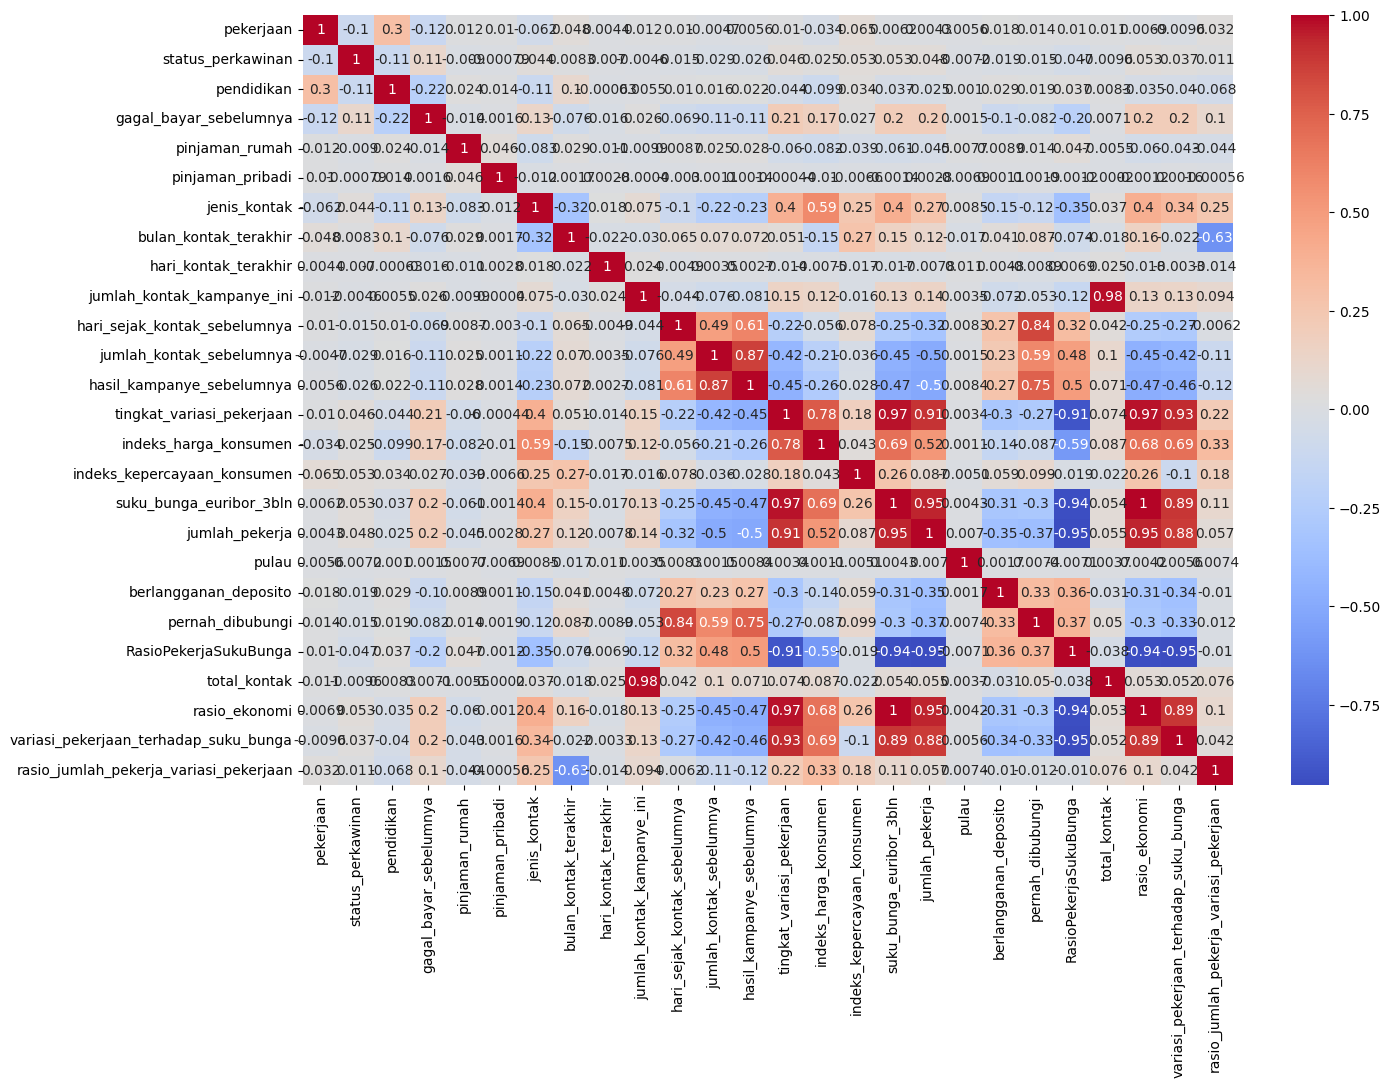

In [464]:
cc_num = cc.select_dtypes(include=np.number)
corelation_matrix = cc_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corelation_matrix, annot=True ,cmap='coolwarm') 

In [465]:
cc_validation.dtypes


usia                                        int64
pekerjaan                                    int8
status_perkawinan                            int8
pendidikan                                  int64
gagal_bayar_sebelumnya                       int8
pinjaman_rumah                               int8
pinjaman_pribadi                             int8
jenis_kontak                                 int8
bulan_kontak_terakhir                       int64
hari_kontak_terakhir                        int64
jumlah_kontak_kampanye_ini                  int64
hari_sejak_kontak_sebelumnya                int64
jumlah_kontak_sebelumnya                    int64
hasil_kampanye_sebelumnya                   int64
tingkat_variasi_pekerjaan                 float64
indeks_harga_konsumen                     float64
indeks_kepercayaan_konsumen               float64
suku_bunga_euribor_3bln                   float64
jumlah_pekerja                            float64
pulau                                        int8


In [466]:
cc.dtypes


usia                                      category
pekerjaan                                     int8
status_perkawinan                             int8
pendidikan                                   int64
gagal_bayar_sebelumnya                        int8
pinjaman_rumah                                int8
pinjaman_pribadi                              int8
jenis_kontak                                  int8
bulan_kontak_terakhir                        int64
hari_kontak_terakhir                         int64
jumlah_kontak_kampanye_ini                   int64
hari_sejak_kontak_sebelumnya                 int64
jumlah_kontak_sebelumnya                     int64
hasil_kampanye_sebelumnya                    int64
tingkat_variasi_pekerjaan                  float64
indeks_harga_konsumen                      float64
indeks_kepercayaan_konsumen                float64
suku_bunga_euribor_3bln                    float64
jumlah_pekerja                             float64
pulau                          

In [467]:
cc.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 22587 entries, 0 to 22915
Empty DataFrame


In [468]:
# cc[cc.select_dtypes(include='boolean').columns] = cc.select_dtypes(include='boolean').astype(float)

In [469]:
cc.isnull().sum()

usia                                      0
pekerjaan                                 0
status_perkawinan                         0
pendidikan                                0
gagal_bayar_sebelumnya                    0
pinjaman_rumah                            0
pinjaman_pribadi                          0
jenis_kontak                              0
bulan_kontak_terakhir                     0
hari_kontak_terakhir                      0
jumlah_kontak_kampanye_ini                0
hari_sejak_kontak_sebelumnya              0
jumlah_kontak_sebelumnya                  0
hasil_kampanye_sebelumnya                 0
tingkat_variasi_pekerjaan                 0
indeks_harga_konsumen                     0
indeks_kepercayaan_konsumen               0
suku_bunga_euribor_3bln                   0
jumlah_pekerja                            0
pulau                                     0
berlangganan_deposito                     0
pernah_dibubungi                          0
RasioPekerjaSukuBunga           

In [470]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22587 entries, 0 to 22915
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   usia                                    22587 non-null  category
 1   pekerjaan                               22587 non-null  int8    
 2   status_perkawinan                       22587 non-null  int8    
 3   pendidikan                              22587 non-null  int64   
 4   gagal_bayar_sebelumnya                  22587 non-null  int8    
 5   pinjaman_rumah                          22587 non-null  int8    
 6   pinjaman_pribadi                        22587 non-null  int8    
 7   jenis_kontak                            22587 non-null  int8    
 8   bulan_kontak_terakhir                   22587 non-null  int64   
 9   hari_kontak_terakhir                    22587 non-null  int64   
 10  jumlah_kontak_kampanye_ini              22587 non-n

# Modeling

In [471]:
from cuml.ensemble import RandomForestClassifier
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from xgboost import plot_importance
import optuna
import cudf
import cupy as cp
import sqlite3

In [472]:
storage_url = "sqlite:////kaggle/working/DataQuest/optuna_study3.db"

In [473]:
# cc = cudf.DataFrame(cc)

In [474]:
# X_train = cc.drop(columns=['berlangganan_deposito'], axis=1)
# y_train = cc['berlangganan_deposito']
# X_val = cc_validation

# count_negative = y_train.value_counts()[0]
# count_positive = y_train.value_counts()[1]
# scale_pos_weight = count_negative/count_positive

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# X_train.columns = X_train.columns.astype(str)
# X_val.columns = X_val.columns.astype(str)

# def objective(trial):
#     param = {
#         'device':'cuda',     
#         'predictor':'gpu_predictor',
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'booster': 'gbtree',
#         'enable_categorical': True,
#         'scale_pos_weight': scale_pos_weight,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 8),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.0, 0.5),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),
#         'random_state': 42
#     }

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     cv_results = xgb.cv(
#         params=param,
#         dtrain=dtrain,
#         num_boost_round=1000, 
#         nfold=5,
#         stratified=True,
#         metrics={'auc'}, 
#         early_stopping_rounds=35,
#         seed=42,
#         verbose_eval=False 
#     )
#     best_auc = cv_results['test-auc-mean'].max()
#     optimal_boost_rounds = cv_results['test-auc-mean'].idxmax() + 1
#     trial.set_user_attr('optimal_boost_rounds', optimal_boost_rounds)
#     return best_auc
    

# study = optuna.create_study(direction='maximize', study_name='XGboost_Study1',storage=storage_url, load_if_exists=True)
# study.optimize(objective, n_trials = 10)

# best_params = study.best_params
# print("best parameter found from CV", best_params)

# optimal_n_estimators = study.best_trial.user_attrs.get('optimal_boost_rounds', 500)
# print(f"Optimal number of estimators from best trial's CV: {optimal_n_estimators}")

# final_model_params = best_params.copy()
# final_model_params['device'] = 'cuda'
# final_model_params['predictor'] = 'gpu_predictor'
# final_model_params['objective'] = 'binary:logistic' 
# final_model_params['eval_metric'] = 'auc'           
# final_model_params['scale_pos_weight'] = scale_pos_weight


# best_model = xgb.XGBClassifier(**final_model_params, n_estimators=optimal_n_estimators, use_label_encoder=False)
# best_model.fit(X_train, y_train,verbose=False)

# y_pred = best_model.predict_proba(X_val)
# print(y_pred[:10]) 

In [475]:
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Fitur Paling Penting (by gain)")
plt.show()

NameError: name 'best_model' is not defined

In [ ]:
print(y_pred)
print(costumer_idval)
submission = cudf.DataFrame({'customer_number': costumer_idval ,'berlangganan_deposito': y_pred[:,1]})
submission.to_csv("DCM_DMU_2025_Model_Batok_kelapa.csv", index=False)